## TUIA - Aprendizaje Automático 1

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian



El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [113]:
!pip install pandas scikit-learn seaborn imblearn


In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression, ElasticNetCV, RidgeCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import shap
import warnings
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

In [115]:
def show_metrics_regresion(y, y_pred, title, nr_neuronal=True):
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    print(title)
    print("Mean Squared Error :", mse)
    print("R-squared:", r2)
    print("Mean Absolute Error (MAE):", mae)
    if nr_neuronal:
        mape = np.mean(np.abs((y - y_pred) / y)) * 100
        print("Mean Absolute Percentage Error (MAPE):", mape)
    
    


## Importar el dataset

In [116]:
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',')

## Filtramos por las ciudades de interés y convertimos a formato date la fecha


In [117]:
ciudades = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']
df = df[df['Location'].isin(ciudades)]
df['Date'] = pd.to_datetime(df['Date'])

## Visualizamos la distribución de los datos por año

In [ ]:
df['Year'] = pd.to_datetime(df['Date']).dt.year # Creamos la columna Year para poder realizar la visualización por año

# Contamos la cantidad de datos por año
data_by_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
data_by_year.plot(kind='bar', color='skyblue')
plt.title('Cantidad de datos por año (2007-2017)')
plt.xlabel('Año')
plt.ylabel('Cantidad de datos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
df = df.drop(columns=['Year']) # Eliminamos la columna Year

## Realizamos el split de entrenamiento y prueba 

Decidimos dividir el conjunto de datos de forma manual. Esta elección se debe a que posteriormente imputaremos los valores basados en la fecha. Si utilizáramos la función train_test_split, la separación sería aleatoria, lo que podría provocar una fuga de datos.


In [ ]:
# Definimos las fechas límite para la división
date_train_limit = pd.to_datetime('2015-10-06')

# Filtramos el DataFrame para obtener los conjuntos de entrenamiento y prueba
train = df[df['Date'] <= date_train_limit]
test = df[df['Date'] > date_train_limit]

print(f"El conjunto de entrenamiento tiene {len(train)} registros y va hasta la fecha {date_train_limit}.")
print(f"El conjunto de prueba tiene {len(test)} registros y empieza a partir de la fecha {date_train_limit}.")

## Análisis descriptivo

Se realizará un análisis exploratorio del conjunto de datos de entrenamiento para entender sus características principales y determinar si se requiere alguna acción para abordar datos faltantes, valores atípicos, la codificación de variables categóricas u otros procesos antes de proceder.

In [ ]:
train.columns

In [ ]:
train.head()

In [ ]:
train.info()
train.isna().sum()

### **Hay un total de 22590 datos de entrenamiento, 25 columnas y se puede observar que hay datos nulos en la mayoria de las variables.**

### Eliminamos la columna 'Unnamed: 0' y 'Location'
Eliminamos la columna Location ya que vamos a considerarlas a todas como una sola

In [ ]:
train = train.drop(columns=['Unnamed: 0', 'Location'])

### Cambiamos los valores nulos
Debido a que tomamos las ciudades como una única localidad, decidimos reemplazar los valores faltantes por otro de la misma fecha o, en su defecto por la mas cercana.

In [ ]:
train.sort_values(by='Date', inplace=True)
train.fillna(method='ffill', inplace=True)

In [ ]:
train.isna().sum()

### Eliminamos la columna Date:
La razon es que ya no la vamos a usar, solo la usamos como criterio para el reemplazo de los valores nulos

In [ ]:
train = train.drop(columns=['Date'])

In [ ]:
train.columns

## Creación de columnas 
Con el objetivo de reducir la cantidad de columnas y mejorar la explicabilidad del modelo, decidimos agrupar las variables que representan dos momentos del día en una sola columna.

In [ ]:
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
train['PressureVariation'] = train['Pressure3pm'] - train['Pressure9am']
train['TempVariation'] = train['Temp3pm'] - train['Temp9am']
train['HumidityVariation'] = train['Humidity3pm'] - train['Humidity9am']
train['CloudVariation'] = train['Cloud3pm'] - train['Cloud9am']
train['WindSpeedVariation'] = train['WindSpeed3pm'] - train['WindSpeed9am']
train.drop(columns=columns_to_aggregate, inplace=True)


In [ ]:
train.columns

### Estadística descriptiva de las variables numéricas
Examinamos medidas estadísticas, incluyendo valores mínimos, máximos, cuartiles, y medidas de centralidad como la mediana y la media.

In [ ]:
train.describe()

Al analizar las columnas, se percibe que tanto la media como la mediana muestran una cercanía notable, lo que sugiere una tendencia consistente en los datos. Los desvíos en la dispersión de los datos no son extremos y la distribución no presentaria una gran extensión en un boxplot.

Los valores mínimos y máximos registrados estan considerablemente alejados de los valores centrales, lo cual señala la posible existencia de valores atípicos dentro del conjunto de datos.

## **Bloxplot**

In [ ]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

colores = sns.color_palette('husl', n_colors=len(numeric_columns))

fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(15, 20), sharex=False)

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=train, x=col, ax=axes[i], color=colores[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('')

plt.tight_layout()

plt.show()

## Histograma

In [ ]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(train[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()

Para comprender más a fondo el comportamiento de los datos, empleamos histogramas donde se puede apreciar que algunas variables exhiben una distribución más uniforme de sus valores, como es el caso de la temperatura, humedad y presión. Por otro lado, existen variables que muestran la presencia de múltiples modas en los datos y una distribución menos uniforme.

Asimismo, se destaca que la variable Rainfall concentra la gran mayoría de sus datos en cero.

## Analizamos nuestra variable objetivo, la que queremos predecir para saber si el dataset esta balanceado o no.
Primero convertimos las variables categóricas en numéricas

In [ ]:
train['RainToday'] = train['RainToday'].map({'No': 0, 'Yes': 1})
train['RainTomorrow'] = train['RainTomorrow'].map({'No': 0, 'Yes': 1})

test['RainToday'] = test['RainToday'].map({'No': 0, 'Yes': 1})
test['RainTomorrow'] = test['RainTomorrow'].map({'No': 0, 'Yes': 1})

In [ ]:
# Calculamos los porcentajes para el conjunto de entrenamiento
train_percentages = train['RainTomorrow'].value_counts(normalize=True) * 100
# Calculamos los porcentajes para el conjunto de prueba
test_percentages = test['RainTomorrow'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='RainTomorrow', data=train)
plt.title('Distribución de RainTomorrow - Train')
for i, value in enumerate(train_percentages):
    plt.text(i, train['RainTomorrow'].value_counts()[i], f'{value:.2f}%', ha='center')

plt.subplot(1, 2, 2)
sns.countplot(x='RainTomorrow', data=test)
plt.title('Distribución de RainTomorrow - Test')
for i, value in enumerate(test_percentages):
    plt.text(i, test['RainTomorrow'].value_counts()[i], f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()


### Se observa que tanto en el conjuntos de entrenamiento como en el de prueba hay una mayor cantidad de datos donde no llueve (0) comparado con los días que llueve (1). Esto puede hacer que el modelo tenga un sesgo muy importante al momento de predecir. Por esta razón, podemos decir que los datos no se encuentran balanceados.
### Podemos ver una relacion 3 a 1 aproximadamente, en este caso existe la posibilidad de balancear el dataset.

# Matriz de correlación 

In [ ]:
numeric_columns = numeric_columns.append(pd.Index(['RainTomorrow']))
correlation_matrix_numeric = train[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Podemos observar que las variables con mayor correlación positiva con RainfallTomorrow son:

*   Rainfall (0.25)
*   HumidityVariation (0.22)
*   WindGustSpeed (0.17)

Las variables con mayor correlación negativa con RainfallTomorrow son:
*   Sunshine (-0.28)
*   TempVariation (-0.23)

Las variables con mayor correlación positiva con RainTomorrow son:

*   RainfallTomorrow (0.55)
*   HumidityVariation (0,27)
*   Rainfall (0.24)
*   WindGustSpeed (0,24)

Las variables con mayor correlación negativa con RainTomorrow son:
*   Sunshine (-0.37)
*   TempVariation (-0.32)

## Para poder ver las metricas de test necesitamos aplicarle los mismos cambios que se hicieron en train.

In [ ]:
test.sort_values(by='Date', inplace=True)

for column in test.columns:
    test[column] = test[column].ffill()
    test[column] = test[column].bfill() 
    
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
test = test.drop(columns=['Unnamed: 0', 'Location','Date'])
test['PressureVariation'] = test['Pressure3pm'] - test['Pressure9am']
test['TempVariation'] = test['Temp3pm'] - test['Temp9am']
test['HumidityVariation'] = test['Humidity3pm'] - test['Humidity9am']
test['CloudVariation'] = test['Cloud3pm'] - test['Cloud9am']
test['WindSpeedVariation'] = test['WindSpeed3pm'] - test['WindSpeed9am']
test.drop(columns=columns_to_aggregate, inplace=True)


# Método LinearRegression

Evaluamos el modelo con los datos de entrenamiento y luego con los de test

In [ ]:
X_train = train.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_train = train['RainfallTomorrow']
X_test = test.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_test = test['RainfallTomorrow']
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")

### Crear un explainer SHAP


In [ ]:
explainer = shap.Explainer(model, X_train)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Gráfica de Resumen Global
shap.summary_plot(shap_values, X_test)

# Gráfico de Dependencia Local (para la primera característica)
shap.dependence_plot("FeatureName", shap_values, X_test)

# Gráfico de Dependencia Local (para la segunda característica)
shap.dependence_plot("FeatureName", shap_values, X_test)

plt.show()

### podemos ver que la varible mas importante es Rainfall y l variable menos importante MaxTemp. Con esto podemos decir que la Variable Rainfall es una de la mas importante par entender como funciona el modelo

### No se observa presencia de overfiting, podemos notar que las metricas de train y test son bastante similares

# Método de gradiente descendiente

In [ ]:
sgd_model = SGDRegressor(loss='squared_error', max_iter=3000, random_state=42)
sgd_model.fit(X_train, y_train)
y_pred_train = sgd_model.predict(X_train)
y_pred_test = sgd_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")

Notamos en este método, que las métricas de r2 comparadas con la regresión lineal son peores.

# Métodos de regularización Lasso

In [ ]:
# Crear y entrenar el modelo Lasso
lasso_model = Lasso(alpha=0.1)  # alpha es el parámetro de regularización
lasso_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")


## Lasso con validación cruzada

In [ ]:

lasso_cv_model = LassoCV(cv=5)
lasso_cv_model.fit(X_train, y_train)
y_pred_train_cv = lasso_cv_model.predict(X_train)
y_pred_test_cv = lasso_cv_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_cv, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_cv, "Métricas sobre los datos de prueba:")


## Lasso con random_search

In [ ]:
# Define los rangos de valores para los hiperparámetros que quieres explorar
param_distributions = {
    'alpha': uniform(0.1, 100.0),  # Rango uniforme entre 0.1 y 100.0 para alpha
}
# Crea una instancia del modelo Lasso
lasso_model = Lasso()
# Crea una instancia de RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lasso_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=10,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)

# Entrena el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print(f"Mejores hiperparámetros encontrados:{random_search.best_params_}" )
# Hacer predicciones con el mejor modelo encontrado
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)

show_metrics_regresion(y_train, y_pred_train_rs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_rs, "Métricas sobre los datos de prueba:")


## Lasso con grid_search

In [ ]:
# Define los valores de los hiperparámetros que quieres explorar
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]  # Lista de valores para alpha
}
lasso_model = Lasso()
grid_search = GridSearchCV(estimator=lasso_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada

grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros encontrados:{}".format(grid_search.best_params_))
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_gs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_gs, "Métricas sobre los datos de prueba:")


# Regresión de Ridge

In [ ]:
ridge_model = Ridge(alpha=0.1)  # alpha es el parámetro de regularización
ridge_model.fit(X_train, y_train)
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")


## Ridge con validación cruzada

In [ ]:
alphas = [0.001, 0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]  # Puedes ajustar esta lista según sea necesario
ridge_cv_model = RidgeCV(alphas=alphas)
ridge_cv_model.fit(X_train, y_train)
y_pred_train_cv = ridge_cv_model.predict(X_train)
y_pred_test_cv = ridge_cv_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_cv, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_cv, "Métricas sobre los datos de prueba:")

## Ridge con random_search

In [ ]:

param_distributions = {
    'alpha': uniform(0.1, 100.0),  # Rango uniforme entre 0.1 y 100.0 para alpha
}
ridge_model = Ridge()
random_search = RandomizedSearchCV(estimator=ridge_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=10,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)
random_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{random_search.best_params_}")
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_rs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_rs, "Métricas sobre los datos de prueba:")

## Ridge con grid_search

In [1]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]  # Lista de valores para alpha
}
ridge_model = Ridge()
grid_search = GridSearchCV(estimator=ridge_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada
grid_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{grid_search.best_params_}")
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_gs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_gs, "Métricas sobre los datos de prueba:")


NameError: name 'Ridge' is not defined

## Método de regularización Elasticnet

In [2]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha es el parámetro de regularización, l1_ratio controla la proporción de L1 y L2
elastic_net_model.fit(X_train, y_train)
y_pred_train = elastic_net_model.predict(X_train)
y_pred_test = elastic_net_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")

NameError: name 'ElasticNet' is not defined

## Elasticnet con validación cruzada

In [3]:
alphas = [0.001, 0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]
elastic_net_cv_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)
elastic_net_cv_model.fit(X_train, y_train)
y_pred_train_cv = elastic_net_cv_model.predict(X_train)
y_pred_test_cv = elastic_net_cv_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_cv, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_cv, "Métricas sobre los datos de prueba:")


NameError: name 'ElasticNetCV' is not defined

## Elasticnet con random_search

In [4]:
param_distributions = {
    'alpha': uniform(0.01, 10.0),  # Rango uniforme entre 0.1 y 10.0 para alpha
    'l1_ratio': uniform(0, 1),     # Rango uniforme entre 0 y 1 para l1_ratio
}
elastic_net_model = ElasticNet()
random_search = RandomizedSearchCV(estimator=elastic_net_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=100,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)

random_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{random_search.best_params_}")
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_rs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_rs, "Métricas sobre los datos de prueba:")


NameError: name 'uniform' is not defined

## Elasticnet con grid_search

In [5]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0],  # Lista de valores para alpha
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Lista de valores para l1_ratio
}
elastic_net_model = ElasticNet()
grid_search = GridSearchCV(estimator=elastic_net_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada
grid_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{grid_search.best_params_}")
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_gs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_gs, "Métricas sobre los datos de prueba:")

NameError: name 'ElasticNet' is not defined

### Con respecto a las métricas, elegimos el r2 para comparar los distintos modelos
### Necesitamos comparar los resultados obtenidos tanto en entrenamiento como en prueba para poder determinar si nuestro modelo esta ajustando correctamente.


# Regresión Logística

### Definimos las variables para clasificación

In [6]:
y_train_clasification =train['RainTomorrow']
y_test_clasification = test['RainTomorrow']

NameError: name 'train' is not defined

In [7]:
logistic_model1 = LogisticRegression(random_state=42)
logistic_model1.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model1.predict(X_train)
y_pred_test = logistic_model1.predict(X_test)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

NameError: name 'LogisticRegression' is not defined

### Crear un explainer SHAP para el modelo de clasificacion

In [8]:
explainer = shap.Explainer(logistic_model1, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.dependence_plot("FeatureName", shap_values, X_test)
shap.dependence_plot("FeatureName", shap_values, X_test)
plt.show()

NameError: name 'shap' is not defined

In [9]:
### podemos observar que las variables que explicar mejor al modelo en este caso son WindGustSpeed , Rainfall. Por otro ldo podemos observar que la variable que menos los explica es CloudVariation

## Regresión logística con penalización por clases

In [10]:
logistic_model2 = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model2.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model2.predict(X_train)
y_pred_test = logistic_model2.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

NameError: name 'LogisticRegression' is not defined

## Regresión logística con balanceo de clases SMOTE

In [11]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_clasification)

NameError: name 'SMOTE' is not defined

In [ ]:
logistic_model3 = LogisticRegression(random_state=42)
logistic_model3.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred_train = logistic_model3.predict(X_train)
y_pred_test = logistic_model3.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

In [ ]:
# Obtener las probabilidades de predicción de la clase positiva para entrenamiento y prueba para cada modelo
y_pred_proba_train1 = logistic_model1.predict_proba(X_train)[:, 1]
y_pred_proba_test1 = logistic_model1.predict_proba(X_test)[:, 1]

y_pred_proba_train2 = logistic_model2.predict_proba(X_train)[:, 1]
y_pred_proba_test2 = logistic_model2.predict_proba(X_test)[:, 1]

y_pred_proba_train3 = logistic_model3.predict_proba(X_train)[:, 1]
y_pred_proba_test3 = logistic_model3.predict_proba(X_test)[:, 1]

# Calcular la curva ROC para entrenamiento y prueba para cada modelo
fpr_train1, tpr_train1, _ = roc_curve(y_train_clasification, y_pred_proba_train1)
fpr_test1, tpr_test1, _ = roc_curve(y_test_clasification, y_pred_proba_test1)
auc_train1 = roc_auc_score(y_train_clasification, y_pred_proba_train1)
auc_test1 = roc_auc_score(y_test_clasification, y_pred_proba_test1)

fpr_train2, tpr_train2, _ = roc_curve(y_train_clasification, y_pred_proba_train2)
fpr_test2, tpr_test2, _ = roc_curve(y_test_clasification, y_pred_proba_test2)
auc_train2 = roc_auc_score(y_train_clasification, y_pred_proba_train2)
auc_test2 = roc_auc_score(y_test_clasification, y_pred_proba_test2)

fpr_train3, tpr_train3, _ = roc_curve(y_train_clasification, y_pred_proba_train3)
fpr_test3, tpr_test3, _ = roc_curve(y_test_clasification, y_pred_proba_test3)
auc_train3 = roc_auc_score(y_train_clasification, y_pred_proba_train3)
auc_test3 = roc_auc_score(y_test_clasification, y_pred_proba_test3)

# Trazar las curvas ROC para entrenamiento y prueba para cada modelo en una sola fila
plt.figure(figsize=(18, 6))

# Modelo 1
plt.subplot(1, 3, 1)
plt.plot(fpr_train1, tpr_train1, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train1)
plt.plot(fpr_test1, tpr_test1, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test1)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')

# Modelo 2
plt.subplot(1, 3, 2)
plt.plot(fpr_train2, tpr_train2, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train2)
plt.plot(fpr_test2, tpr_test2, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística con penalización por clases')
plt.legend(loc='lower right')

# Modelo 3
plt.subplot(1, 3, 3)
plt.plot(fpr_train3, tpr_train3, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train3)
plt.plot(fpr_test3, tpr_test3, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test3)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística con balanceo de clases SMOTE')
plt.legend(loc='lower right')

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

### Podemos notar que al aplicar el método de sobre muestreo SMOTE o la regresión logística con penalización a la clase minoritaria podemos notar una mejora en los valores de recall

## Modelo Clasificar base 

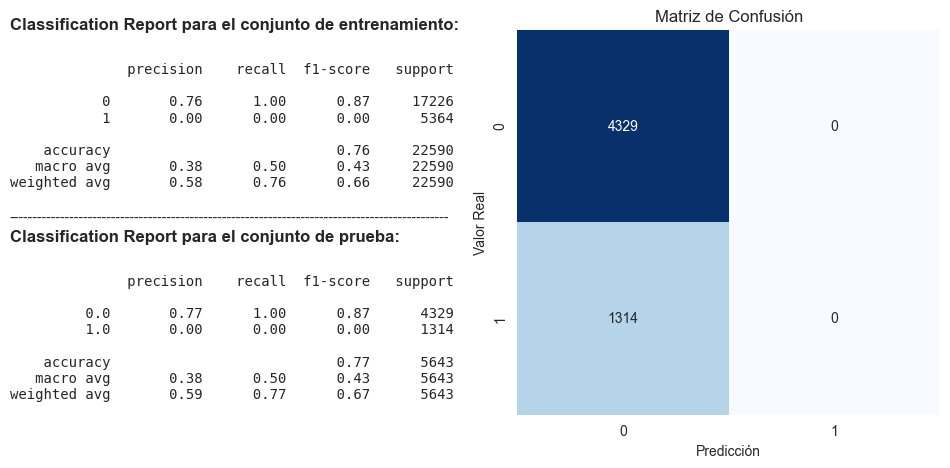

<Figure size 400x300 with 0 Axes>

In [99]:
# Crear el clasificador ingenuo que predice la clase mayoritaria
naive_classifier = DummyClassifier(strategy="most_frequent")

# Entrenar el modelo con los datos de entrenamiento
naive_classifier.fit(X_train, y_train_clasification)

# Hacer predicciones sobre los datos de entrenamiento y prueba
y_pred_train = naive_classifier.predict(X_train)
y_pred_test = naive_classifier.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')
ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## curva ROC de modelo base

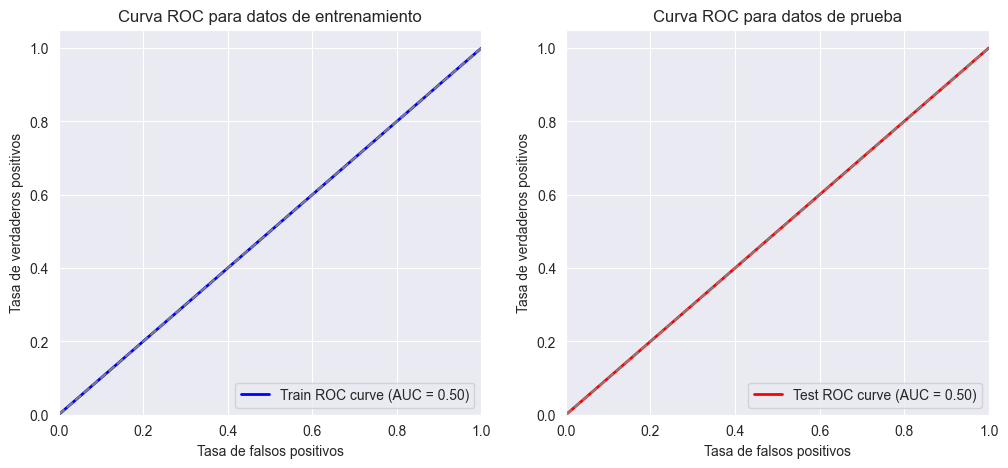

In [100]:
# Obtener las probabilidades de predicción de la clase positiva (la clase mayoritaria)
y_pred_proba_train = np.full_like(y_train_clasification, fill_value=1)  # Clase mayoritaria
y_pred_proba_test = np.full_like(y_test_clasification, fill_value=1)  # Clase mayoritaria

# Calcular la curva ROC para los datos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test_clasification, y_pred_proba_test)

# Calcular el área bajo la curva ROC (AUC) para los datos de entrenamiento y prueba
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Crear la figura con dos subplots uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Trazar la curva ROC para los datos de entrenamiento
ax1.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (AUC = %0.2f)' % auc_train)
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de falsos positivos')
ax1.set_ylabel('Tasa de verdaderos positivos')
ax1.set_title('Curva ROC para datos de entrenamiento')
ax1.legend(loc='lower right')

# Trazar la curva ROC para los datos de prueba
ax2.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (AUC = %0.2f)' % auc_test)
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Tasa de falsos positivos')
ax2.set_ylabel('Tasa de verdaderos positivos')
ax2.set_title('Curva ROC para datos de prueba')
ax2.legend(loc='lower right')

# Mostrar la figura
plt.show()


## Modelo Regresion base 

In [101]:
# Crear un DummyRegressor que predice la media de la variable objetivo
dummy_regressor = DummyRegressor(strategy='mean')

# Entrenar el modelo de regresión base con los datos de entrenamiento
dummy_regressor.fit(X_train, y_train)

# Hacer predicciones con el modelo de regresión base en los datos de entrenamiento y prueba
y_pred_train_base = dummy_regressor.predict(X_train)
y_pred_test_base = dummy_regressor.predict(X_test)

# Calcular el error cuadrático medio (MSE) del modelo de regresión base para el conjunto de entrenamiento y prueba
mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base = mean_squared_error(y_test, y_pred_test_base)

# Calcular el Error Absoluto Medio (MAE) para el conjunto de entrenamiento y prueba
mae_train_base = mean_absolute_error(y_train, y_pred_train_base)
mae_test_base = mean_absolute_error(y_test, y_pred_test_base)

# Calcular el Error Porcentual Absoluto Medio (MAPE) para el conjunto de prueba
mape_test_base = np.mean(np.abs((y_test - y_pred_test_base) / y_test)) * 100

# Calcular el coeficiente de determinación (R-cuadrado) para el conjunto de prueba
r2_test_base = r2_score(y_test, y_pred_test_base)

# Imprimir las métricas
print("Métricas para el modelo de regresión base:")
print("Error cuadrático medio (MSE) (Train):", mse_train_base)
print("Error cuadrático medio (MSE) (Test):", mse_test_base)
print("Mean Absolute Error (MAE) (Train):", mae_train_base)
print("Mean Absolute Error (MAE) (Test):", mae_test_base)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_base)
print("R-squared (Test):", r2_test_base)


Métricas para el modelo de regresión base:
Error cuadrático medio (MSE) (Train): 39.33047103465534
Error cuadrático medio (MSE) (Test): 44.68189308133037
Mean Absolute Error (MAE) (Train): 2.995796672637569
Mean Absolute Error (MAE) (Test): 3.1453231475225363
Mean Absolute Percentage Error (MAPE) (Test): inf
R-squared (Test): -0.00041781852103839334


# Red neuronal para Regresion

In [102]:
model = Sequential()
model.add(Dense(32, input_shape=(12,), activation='relu'))
model.add(Dense(1, activation='linear')) 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

show_metrics_regresion(y_train, y_pred_train,"Métricas del conjunto de entrenamiento:", False)
show_metrics_regresion(y_test, y_pred_test,"Métricas del conjunto de Prueba:", False)

2024-05-02 16:31:20.899292: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - loss: 46.9488 - val_loss: 30.4674
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 31.3806 - val_loss: 29.1624
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 32.6167 - val_loss: 28.8350
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 28.3312 - val_loss: 29.3377
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 33.2254 - val_loss: 27.9966
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 32.2590 - val_loss: 28.1996
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 25.0161 - val_loss: 27.8253
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 31.6010 - val_loss: 27.4726
Epoch 9/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 30.4930 - val_loss: 28.3397
Epoch 10/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 29.6488 - val_loss: 27.6051
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
Métricas del 

# Optuna

In [103]:
def objective(trial):
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    hidden_layer_size = trial.suggest_int('hidden_layer_size', 16, 64)
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_shape=(12,), activation='relu'))
    for _ in range(num_hidden_layers):
        model.add(Dense(hidden_layer_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Definir EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Entrenar el modelo con EarlyStopping
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    return mse_train

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

best_params = study.best_params
best_model = Sequential()
best_model.add(Dense(best_params['hidden_layer_size'], input_shape=(12,), activation='relu'))
for _ in range(best_params['num_hidden_layers']):
    best_model.add(Dense(best_params['hidden_layer_size'], activation='relu'))
best_model.add(Dense(1, activation='linear'))
best_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)
y_pred_test = best_model.predict(X_test)
print("Mejores Hiperparámetros:", best_params)
show_metrics_regresion(y_test, y_pred_test,"conjunto de prueba:",nr_neuronal=False)


[I 2024-05-02 16:31:38,664] A new study created in memory with name: no-name-878bd269-0800-441d-81a9-5f466c9ed916


706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


[I 2024-05-02 16:31:46,052] Trial 0 finished with value: 28.108529547346397 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 36}. Best is trial 0 with value: 28.108529547346397.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
Mejores Hiperparámetros: {'num_hidden_layers': 1, 'hidden_layer_size': 36}
conjunto de prueba:
Mean Squared Error : 31.569047086709286
R-squared: 0.29317593679866294
Mean Absolute Error (MAE): 2.372095041917335


# Red neuronal para Clasificacion


In [109]:
# Construir el modelo de red neuronal
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train_clasification, epochs=10, batch_size=32, validation_split=0.2)

train_loss, train_accuracy = model.evaluate(X_train, y_train_clasification, verbose=0)
print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Pérdida en el conjunto de entrenamiento:", train_loss)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Precisión en el conjunto de prueba:", test_accuracy)
print("Pérdida en el conjunto de prueba:", test_loss)




Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7899 - loss: 0.5429 - val_accuracy: 0.7979 - val_loss: 0.4440
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.8181 - loss: 0.4149 - val_accuracy: 0.8112 - val_loss: 0.4260
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.8205 - loss: 0.4073 - val_accuracy: 0.8081 - val_loss: 0.4313
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.8243 - loss: 0.4058 - val_accuracy: 0.8132 - val_loss: 0.4284
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.8277 - loss: 0.3989 - val_accuracy: 0.8243 - val_loss: 0.4191
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.8241 - loss: 0.4033 - val_accuracy: 0.8174 - val_loss: 0.4201
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.8217 - loss: 0.4023 - val_accuracy: 0.8240 - val_loss: 0.4176
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.8263 - loss: 0.4033 - va

## optimizacion de hiper-parametros

In [112]:
best_accuracy = 0.0  # Seguimiento de la mejor precisión encontrada
def objective(trial):
    global best_accuracy  # Para acceder a la variable global

    # Definir los hiperparámetros a optimizar
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    hidden_layer_size = trial.suggest_int('hidden_layer_size', 16, 64)

    # Construir el modelo de red neuronal
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_shape=(X_train.shape[1],), activation='relu'))
    for _ in range(num_hidden_layers):
        model.add(Dense(hidden_layer_size, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(X_train, y_train_clasification, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluar el modelo en el conjunto de prueba
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Si es el mejor modelo hasta ahora, actualizar la mejor precisión encontrada
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
    
    return test_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

best_params = study.best_params

# Construir el mejor modelo con los mejores hiperparámetros
best_model = Sequential()
best_model.add(Dense(best_params['hidden_layer_size'], input_shape=(X_train.shape[1],), activation='relu'))
for _ in range(best_params['num_hidden_layers']):
    best_model.add(Dense(best_params['hidden_layer_size'], activation='relu'))
best_model.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria

best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_model.fit(X_train, y_train_clasification, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluar el mejor modelo en el conjunto de entrenamiento y de prueba
train_loss, train_accuracy = best_model.evaluate(X_train, y_train_clasification, verbose=0)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print("Mejores hiperparámetros:", best_params)
print("\nMétricas del mejor modelo:")
print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Pérdida en el conjunto de entrenamiento:", train_loss)
print("Precisión en el conjunto de prueba:", test_accuracy)
print("Pérdida en el conjunto de prueba:", test_loss)


[I 2024-05-02 16:48:37,433] A new study created in memory with name: no-name-aead9489-b231-4a26-890d-bd01ea5d0167
[I 2024-05-02 16:49:06,082] Trial 0 finished with value: 0.5936558842658997 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 61}. Best is trial 0 with value: 0.5936558842658997.


Mejores hiperparámetros: {'num_hidden_layers': 2, 'hidden_layer_size': 61}

Métricas del mejor modelo:
Precisión en el conjunto de entrenamiento: 0.8472332954406738
Pérdida en el conjunto de entrenamiento: 0.35961100459098816
Precisión en el conjunto de prueba: 0.5924153923988342
Pérdida en el conjunto de prueba: -0.7526833415031433


### basado en las metricas obtenidas vamos a usar La regresion logistica para el problema de clasificacion, y para el problema de regresion la res neuronal